In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import scipy.io

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

GPU is available


# Ecuación de Advection
Sea $\Omega = [0,1]\times [0,2\pi]$. Determinar $u(t,x)$ que satisfaga: 

1. $$u_t + c\, u_x = 0 \hspace{0.8cm}  \text{En el interior de } \Omega$$

2. $$u(0,x) = g(x) \hspace{0.8cm}  x\in (0,2\pi) $$

Considere el caso $c=50$ y $g(x) = \sin(x)$.

## Solución de Referencia

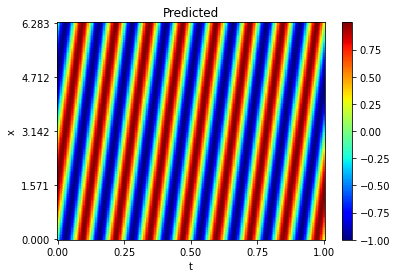

In [31]:
T = 1.0 
L = 2*np.pi
c = 50.0 
n_t = 200
n_x = 128

t_star = np.linspace(0, T, n_t)
x_star = np.linspace(0, L, n_x)

def u_exact(t,x):
    phase = x - c*t
    mod_phase = phase % (L)
    return np.sin(mod_phase)

T,X = np.meshgrid(t_star, x_star)
Z  = u_exact(T, X)

#Garafica solución de referencia
plt.figure()
cp = plt.pcolor(T, X, Z, shading='auto', cmap='jet')
plt.colorbar(cp)  # Añade una barra de color
plt.title('Predicted')
plt.xlabel('t')
plt.ylabel('x')
plt.xticks(np.linspace(0, 1, 5))
plt.yticks(np.linspace(0, 2*np.pi, 5))
plt.axis('tight')  # Ajusta los ejes al rango de los datos
plt.show()
    

## Dominios

In [11]:
#límites del dominio del problema
tmin = 0.0
tmax = 1.0
xmin = 0.0
xmax = 2*np.pi

In [38]:
#puntos donde la función de perdida satisface la ecuacion diferencia 1.
N_r = 1200
t_r = tf.constant(tmin + (tmax - tmin)*np.random.random(N_r), shape = (N_r,1), dtype = DTYPE)
x_r = tf.constant(xmin + (xmax - xmin)*np.random.random(N_r), shape = (N_r,1), dtype = DTYPE)
X_r = tf.concat([t_r, x_r], axis = 1)
#plt.scatter(t_r, x_r, marker = 'x', color = 'b')
#plt.xlabel('t')
#plt.ylabel('x')

In [39]:
N_u = 100 

#puntos del dominio donde se satisface la condición 2.
t_i = tf.zeros((N_u,1), dtype = DTYPE)
x_i = tf.constant(xmin + (xmax - xmin)*np.random.random(N_u), shape = (N_u,1), dtype = DTYPE)
X_i = tf.concat([t_i, x_i], axis = 1)

Text(0, 0.5, 'x')

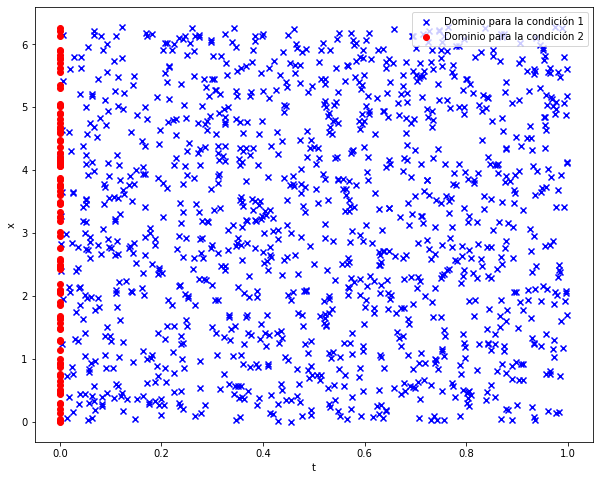

In [40]:
plt.figure(figsize=(10,8))
plt.scatter(t_r, x_r, marker = 'x', color = 'b', label = 'Dominio para la condición 1')
plt.scatter(t_i, x_i, marker = 'o', color = 'r', label = 'Dominio para la condición 2')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('x')

In [41]:
tf.random.shuffle(X_i)[:10]


<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0.       , 4.5968103],
       [0.       , 5.788129 ],
       [0.       , 3.7569947],
       [0.       , 2.5936084],
       [0.       , 5.013747 ],
       [0.       , 1.4816301],
       [0.       , 1.6527145],
       [0.       , 2.0784538],
       [0.       , 2.0931048],
       [0.       , 4.1081867]], dtype=float32)>

## Modelo Pinns

In [42]:
#Red Neuronal
def init_model(num_hidden_layers = 3, num_neurons_per_layer = 20 ):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(2))

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, 
                                        activation = tf.keras.activations.get('tanh'),
                                       kernel_initializer = 'glorot_normal'))
    
    model.add(tf.keras.layers.Dense(1))
    return model

In [64]:
model_1 = init_model()

In [48]:
#residual loss
def f_pinns(model, X):
    t = X[:,0:1]
    x = X[:,1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        u = model(tf.concat([t, x], axis = 1))
    u_t = tape.gradient(u, t)
    u_x = tape.gradient(u, x)
    return u_t + c * u_x

In [54]:
#initial condition
def g(X):
    t = X[:,0:1]
    x = X[:,1:2]
    return tf.sin(x)

In [53]:
#f_pinns(model_1, tf.random.shuffle(X_r)[:800])

In [55]:
#Calculo de la función de pérdida
def compute_loss(model, X_colocacion, X_inicial):
    
    f = f_pinns(model, X_colocacion)
    r = tf.reduce_mean(tf.square(f))

    r_inicial = tf.reduce_mean(tf.square(model(X_inicial) - g(X_inicial)))

    loss = r + r_inicial 
    return loss, r, r_inicial

In [57]:
#compute_loss(model_1, X_r, X_i)

In [58]:
#Derivada de la función de pérdida con respecto a los pesos de la red neuronal
def get_grad_loss(model, X_colocacion, X_inicial):
    with tf.GradientTape() as tape:
        loss, _, _ = compute_loss(model, X_colocacion, X_inicial)
    g = tape.gradient(loss, model.trainable_variables)
    return loss, g

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [74]:
@tf.function
def train_step(model, X_r, X_i):
    X_r_shuffled = tf.random.shuffle(X_r)
    X_i_shuffled = tf.random.shuffle(X_i)
    loss, grads = get_grad_loss(model, X_r_shuffled[:800], X_i_shuffled)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [75]:
N = 2000

for i in range(N+1):
    train_step(model_1, X_r, X_i)
    if i % 100 == 0:
        print(f'Iteración {i}, Pérdida: {loss.numpy()}')
print('Fin del entrenamiento')

2024-05-12 21:45:31.988364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Iteración 0, Pérdida: 0.12542983889579773
Iteración 100, Pérdida: 0.12542983889579773
Iteración 200, Pérdida: 0.12542983889579773
Iteración 300, Pérdida: 0.12542983889579773
Iteración 400, Pérdida: 0.12542983889579773
Iteración 500, Pérdida: 0.12542983889579773
Iteración 600, Pérdida: 0.12542983889579773
Iteración 700, Pérdida: 0.12542983889579773
Iteración 800, Pérdida: 0.12542983889579773
Iteración 900, Pérdida: 0.12542983889579773
Iteración 1000, Pérdida: 0.12542983889579773
Iteración 1100, Pérdida: 0.12542983889579773
Iteración 1200, Pérdida: 0.12542983889579773
Iteración 1300, Pérdida: 0.12542983889579773
Iteración 1400, Pérdida: 0.12542983889579773
Iteración 1500, Pérdida: 0.12542983889579773
Iteración 1600, Pérdida: 0.12542983889579773
Iteración 1700, Pérdida: 0.12542983889579773
Iteración 1800, Pérdida: 0.12542983889579773
Iteración 1900, Pérdida: 0.12542983889579773
Iteración 2000, Pérdida: 0.12542983889579773
Fin del entrenamiento
